In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=0_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 5.089056526198455e-05, 'std': 0.0010900836105367517, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 2.8602779351932217e-05, 'std': 0.0010900836105367517, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 2.204360546055415e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.8415540615294843e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.5980566369620622e-05, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
Elapsed time(grad):5.301
losses=tensor([[7.3229e-03, 2.1844e-03, 9.2363e+00, 8.9315e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.355
Fairn

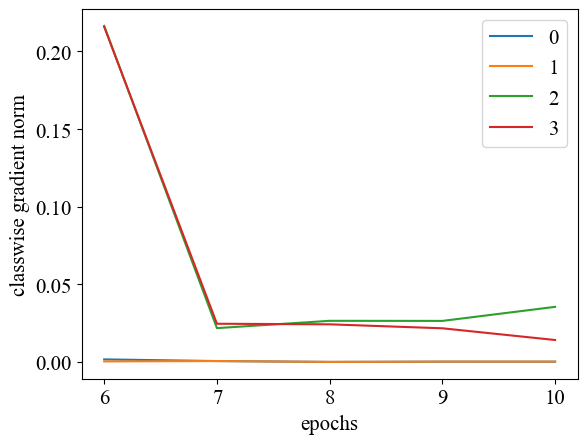

---------------------------- Task 3 -----------------------
Elapsed time(grad):5.011
losses=tensor([[1.0471e-03, 6.5029e-04, 3.3525e-02, 1.8173e-01, 9.8978e+00, 1.1458e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):13.137
Fairness:[ 0.37287824  0.48750281  0.23238372  0.01070903 -0.39439083 -0.70908327]
Current class expected loss:[ 0.          0.          0.          0.         -1.9605162  -2.90459344]
len(updated_seq_indices)=11263
[11] Eval metrics for task 1 >> {'accuracy': 0.9212712397734424, 'loss': 0.0011966297953404997, 'std': 0.03555695405915671, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8315594059405941, 'loss': 0.002203908536389806, 'std': 0.043440594059405924, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9555211292046066, 'loss': 0.0007056349663813315, 'std': 0.026148931895189687, 'EER': -1}
Elapsed time(grad):5.39
losses=tensor([[0.0053, 0.0023, 0.0038, 0.0107, 0.1093, 0.2114]])
### Cplex absolute_and_nonabso

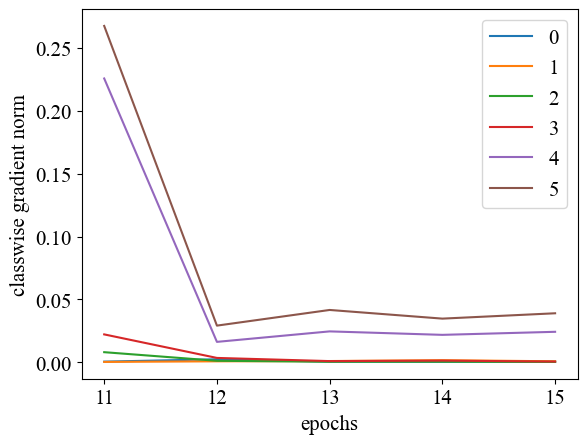

---------------------------- Task 4 -----------------------
Elapsed time(grad):5.788
losses=tensor([[6.5522e-04, 3.5988e-03, 7.9677e-04, 2.2897e-03, 1.1694e-01, 3.3893e-01,
         1.2196e+01, 1.0087e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):18.917
Fairness:[ 0.23637897  0.28280902  0.10193647  0.24058532  0.0814735   0.09215022
 -0.66684252 -0.36849115]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
 -3.32475757 -2.13135263]
len(updated_seq_indices)=12183
[16] Eval metrics for task 1 >> {'accuracy': 0.8667962779825586, 'loss': 0.001988208251641997, 'std': 0.08210240043153827, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.8001937984496124, 'loss': 0.003308733547586185, 'std': 0.00019379844961237014, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.878964865333857, 'loss': 0.0016550293854232022, 'std': 0.020220470715022865, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 

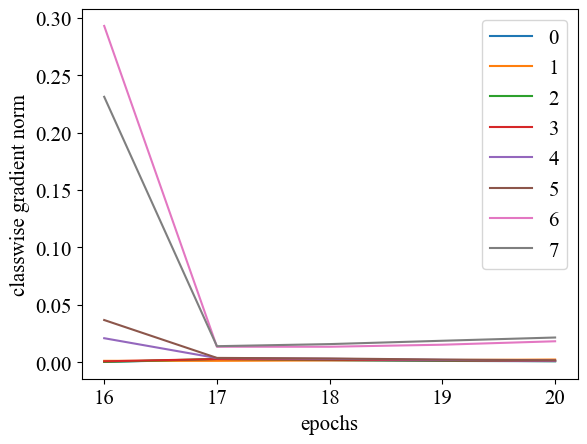

---------------------------- Task 5 -----------------------
Elapsed time(grad):5.554
losses=tensor([[3.0245e-03, 7.2184e-03, 1.8092e-03, 2.3908e-03, 2.9060e-03, 6.3850e-03,
         4.6725e-02, 9.8745e-02, 1.1646e+01, 1.1551e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):21.514
Fairness:[ 0.18210774  0.2171219   0.16927446  0.15224246  0.03335565  0.10683184
  0.12455538  0.07577991 -0.55583515 -0.50543406]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
  0.          0.         -3.32787928 -3.07587431]
len(updated_seq_indices)=11800
[21] Eval metrics for task 1 >> {'accuracy': 0.8679110851389014, 'loss': 0.002154362032599483, 'std': 0.06689067697563611, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7545446695832374, 'loss': 0.00423890001976992, 'std': 0.009990214137692854, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.7895630314266666, 'loss': 0.003006956429720688, 'std': 0.0373208

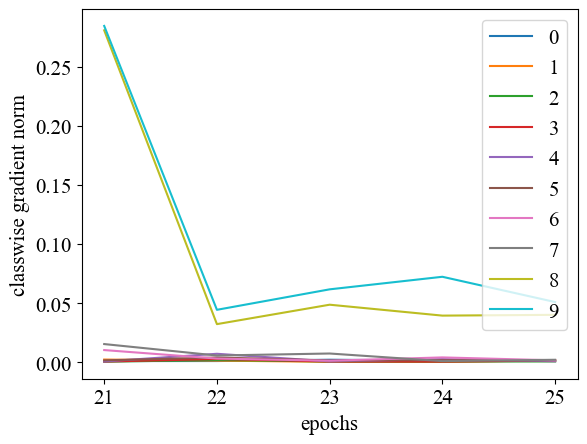

final avg-acc 0.8594599798269087
final avg-forget 0.10512981235404151


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
algorithm.optim_time

{1: {},
 2: {1: 11.355353116989136,
  2: 11.617334365844727,
  3: 11.686113834381104,
  4: 11.514148950576782,
  5: 11.817085266113281},
 3: {1: 13.136533260345459,
  2: 13.664804458618164,
  3: 13.137739419937134,
  4: 13.37250304222107,
  5: 13.64634394645691},
 4: {1: 18.91698718070984,
  2: 20.17350721359253,
  3: 19.700376749038696,
  4: 20.021589040756226,
  5: 18.9769868850708},
 5: {1: 21.514107704162598,
  2: 22.412559509277344,
  3: 22.021579265594482,
  4: 22.354541063308716,
  5: 22.904793977737427}}

In [21]:
for t in algorithm.optim_time:
    if t == 1:
        continue
    print(np.round(np.mean(list(algorithm.optim_time[t].values())), 3), end="\t")

11.598	13.392	19.558	22.242	

In [8]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3
task:4
task:5


In [9]:
num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out

In [11]:
binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})

task:2
task:3
task:4
task:5


In [12]:
binned_weight

{2: [{2: {1.0: 5958}, 3: {1.0: 6131}},
  {2: {0.05: 3565, 0.15: 1, 0.3: 1, 1.0: 2391},
   3: {0.05: 3703, 0.85: 1, 1.0: 2427}},
  {2: {0.05: 4494, 0.65: 1, 1.0: 1463},
   3: {0.05: 4555, 0.1: 1, 0.5: 1, 1.0: 1574}},
  {2: {0.05: 4203, 0.9: 1, 1.0: 1754}, 3: {0.05: 4385, 0.7: 1, 1.0: 1745}},
  {2: {0.05: 4086, 0.35: 1, 0.5: 1, 1.0: 1870}, 3: {0.05: 4304, 1.0: 1827}}],
 3: [{4: {1.0: 5842}, 5: {1.0: 5421}},
  {4: {0.05: 4561, 0.8: 1, 1.0: 1280}, 5: {0.05: 4082, 1.0: 1339}},
  {4: {0.05: 4984, 0.1: 1, 0.3: 1, 0.45: 1, 1.0: 855},
   5: {0.05: 4456, 0.25: 1, 1.0: 964}},
  {4: {0.05: 4936, 0.5: 1, 1.0: 905}, 5: {0.05: 4465, 0.3: 2, 1.0: 954}},
  {4: {0.05: 4970, 1.0: 872}, 5: {0.05: 4468, 0.15: 1, 0.65: 1, 1.0: 951}}],
 4: [{6: {1.0: 5918}, 7: {1.0: 6265}},
  {6: {0.05: 5779, 0.65: 2, 1.0: 137},
   7: {0.05: 6076, 0.75: 2, 0.9: 1, 1.0: 186}},
  {6: {0.05: 5794, 0.5: 2, 1.0: 122},
   7: {0.05: 6085, 0.1: 1, 0.5: 1, 0.8: 1, 1.0: 177}},
  {6: {0.05: 5789, 0.7: 1, 0.85: 1, 1.0: 127},
   7: {0.05

In [13]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.974, 0.952, 0.   , 0.   , 0.   ],
       [0.939, 0.863, 0.935, 0.   , 0.   ],
       [0.867, 0.831, 0.902, 0.937, 0.   ],
       [0.87 , 0.793, 0.826, 0.912, 0.895]])

In [14]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.9235694204362629

In [15]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.011, 0.033, 0.035, 0.04]

In [16]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.02396379373484995

In [17]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.001, 0.011, 0.04, 0.057, 0.059]

In [18]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.03349323536544498

In [19]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9235694204362629
EER:0.02396379373484995
std:0.03349323536544498
